<a href="https://colab.research.google.com/github/PrinceWallyy/CV_DeepLearning/blob/master/CV_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Initialization*

In [ ]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import BatchNormalization
from keras.layers import Activation, Dropout
import matplotlib.pyplot as plt
import os

In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback
!wandb login

     |████████████████████████████████| 1.8MB 25.3MB/s 
     |████████████████████████████████| 133kB 52.4MB/s 
     |████████████████████████████████| 174kB 52.7MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=77294497728d32b6a4e5797bef0ac1859855fe6de7160e4349fd4cc308be521a
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=e5af58d812e76a9bb7c928fa9451ecaff36030619b07dd8ec48bcd66db3b55cf
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: 

In [ ]:
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocess

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Assignment 2 - Deep Learning/data/fer2013.csv', delimiter=',')
emotion_map = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'}

df_train = data[data["Usage"] == "Training"]
df_test_public = data[data["Usage"] == "PublicTest"]
df_test_private = data[data["Usage"] == "PrivateTest"]

image_size = len(df_train['pixels'].iloc[0].split(' '))
width = int(math.sqrt(image_size))
height = int(math.sqrt(image_size))
img_features = df_train['pixels'].apply(lambda x: np.array(x.split()).reshape(height, width, 1).astype('float32'))
img_features = np.stack(img_features, axis=0)
img_features = img_features / 255.0
img_labels = np.array(df_train['emotion'])

X_train, X_valid, y_train, y_valid = train_test_split(img_features, img_labels,
                                                      shuffle=True, stratify=img_labels,
                                                      test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(22967, 48, 48, 1) (5742, 48, 48, 1) (22967,) (5742,)


# CNN

In [ ]:
class CNN():
    def __init__(self, lr, lf, epoch, batch):
        super(CNN, self).__init__()
        self.lr = lr
        self.lf = lf
        self.epoch = epoch
        self.batch = batch

    def build(self):
        model = models.Sequential()
        model.add(layers.Conv2D(32, (8, 8), activation='relu', padding='same', input_shape=(48, 48, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(.5))

        model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(.5))

        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(.5))

        model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(Dropout(.5))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dense(7))
        model.summary()
        return model

    def feed_forward(self):
        model = CNN.build(self)
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

        optimizer = tf.keras.optimizers.Adam(self.lr)
        model.compile(optimizer, self.lf, metrics=['acc'])
        return model

    def evaluate(self):
        model = CNN.feed_forward(self)
        history = model.fit(X_train, y_train, epochs=self.epoch,
                            validation_data=(X_valid, y_valid),
                            batch_size=self.batch,
                            callbacks=[WandbCallback(data_type="image", labels=y_train)])
        loss, accuracy = model.evaluate(X_valid, y_valid)

        plt.plot(history.history['acc'], label='accuracy')
        plt.plot(history.history['val_acc'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        return accuracy

# Main

wandb: Currently logged in as: princewallyy (use `wandb login --relogin` to force relogin)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        2080      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        2

epoch,9
loss,10.48156
acc,0.16833
val_loss,10.48252
val_acc,0.16823
_runtime,114
_timestamp,1621754777
_step,10
best_val_loss,6.7197
best_epoch,0
Test Error Rate,83.18


epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▃████████
acc,▁▂████████
val_loss,▁█████████
val_acc,▁█████████
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
Test Error Rate,▁


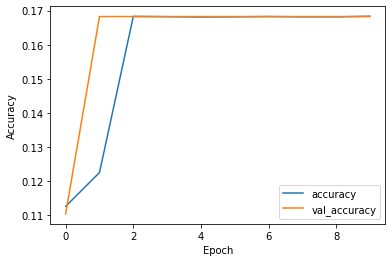

In [ ]:
def main():
    run = wandb.init(project='MU-CV-Assignment2',
                     config={
                         "learning_rate": 0.01,
                         "epochs": 10,
                         "batch_size": 128,
                         "loss_function": "sparse_categorical_crossentropy",
                         "architecture": "CNN",
                         "dataset": "FER-2013"
                     },
                     entity="mu_cv_cnn")
    config = wandb.config
    cnn = CNN(config.learning_rate, config.loss_function, config.epochs, config.batch_size)

    accuracy = cnn.evaluate()
    wandb.log({'Test Error Rate': round((1 - accuracy) * 100, 2)})
    run.join()


if __name__ == '__main__':
    main()
